# PARTIE 1 — Modélisation (Cluster‑First / Route‑Second)

> **Objet du projet.** Planifier des tournées de véhicules pour desservir un ensemble de clients depuis un (ou plusieurs) dépôts, en minimisant un coût total (distance/temps/CO₂) sous contraintes opérationnelles. Nous retenons une **stratégie Cluster‑First / Route‑Second (CFRS)** : d’abord répartir les clients en *grappes* (clusters) compatibles avec les contraintes, puis optimiser l’ordre de visite de chaque grappe.

---

## 1) Contexte, périmètre et objectifs

- **Contexte énergétique** : réduction des distances parcourues ⇒ baisse des émissions et des coûts.
- **Problème adressé** : **VRP** enrichi par deux contraintes *recommandées* pour viser la note A :
  1. **Fenêtres temporelles (VRPTW)** : chaque client *i* doit être servi dans \([a_i, b_i]\), attente autorisée si arrivée avant \(a_i\).
  2. **Flotte hétérogène (HVRP)** : types de véhicules \(k\) avec capacités et coûts différents.
- **Objectif** : produire un modèle formel prêt pour l’implémentation et justifier la complexité ; décrire précisément la méthode CFRS retenue et le formalisme de la métaheuristique (voisinages, fonctions de pénalité, etc.).

> **Extensions optionnelles (version avancée)** — *non obligatoires pour cette partie* mais anticipées par le design : multi‑dépôts, temps de trajet dépendants de l’heure (trafic), compatibilités produit‑véhicule.

## 2) Représentation des données  

- **Géométrie** : graphe orienté $G=(V,E)$ ; $V = \{0\} \cup N$ avec dépôt $0$ et clients $N=\{1,\dots,n\}$.  
  En multi-dépôts : $D\subset V$ est l’ensemble des dépôts.  

- **Distances/temps** : $c_{ij}$ (coût distance/CO₂) et $\tau_{ij}$ (temps de trajet).  
  En version avancée : $\tau_{ij}(t)$ (dépendant de l’heure, par tranches).  

- **Demande et service** : demande $q_i$, durée de service $s_i$, fenêtre $[a_i,b_i]$ par client, horizon $[a_0,b_0]$ au dépôt.  

- **Flotte hétérogène** : ensemble de véhicules $K$, chaque véhicule $k$ a capacité $Q_k$, coût fixe $f_k$, coût kilométrique $\alpha_k$, et éventuellement vitesse moyenne $v_k$.  
  On peut modéliser $K$ comme des véhicules individualisés (nombre limité) ou par types $\mathcal{T}$ avec cardinalités $p_t$.  

- **Objectifs** :  
  - **mono-objectif** : minimiser  
    $$
    \min \sum_{k}\sum_{i,j} c_{ij} x_{ijk} + \sum_k f_k y_k
    $$
  - **multi-objectif** (pondéré) :  
    $$
    \min \omega_d \cdot \text{distance} + \omega_t \cdot \text{temps} + \omega_{\text{CO2}} \cdot \text{émissions}
    $$

**Compatibilité VRPLIB/CVRPLIB.**  
Les champs classiques (coordonnées, demande, capacité, coût) sont directement mappables.  
Pour $[a_i,b_i]$ et $s_i$, utiliser les variantes *VRPTW* ;  
pour flotte hétérogène, exploiter des fichiers étendus ou un *side-car* JSON décrivant $K$.  


## 3) Modèle mathématique (formulation de référence)

On donne une formulation **HVRPTW** (flotte hétérogène + fenêtres temporelles) avec variables d’arcs *par véhicule*.  
Ce modèle sert de base théorique et pour vérifier la faisabilité ; en pratique, l’optimisation sera heuristique (CFRS).

### 3.1 Ensembles, paramètres
- $V = \{0\}\cup N$ (un dépôt) ; extension multi-dépôts en §3.5.  
- $K$ : véhicules hétérogènes.  
- Paramètres : $q_i, s_i, [a_i,b_i], Q_k, f_k, c_{ij}, \tau_{ij}$ et grande constante $M$.

### 3.2 Variables de décision
- $x_{ijk} \in \{0,1\}$ : l’arc $(i,j)$ est utilisé par le véhicule $k$.  
- $y_k \in \{0,1\}$ : le véhicule $k$ est utilisé.  
- $t_i \ge 0$ : heure d’arrivée au sommet $i$ (commune à tous les véhicules puisque $i$ est servi au plus une fois).  
- $u_i \in [q_i, \max_k Q_k]$ : *charge cumulée* livrée juste après service en $i$ (type MTZ capacitaire).

### 3.3 Fonction objectif
$$
\min \; \sum_{k\in K} f_k y_k
\; + \; \sum_{k\in K} \sum_{i\in V} \sum_{j\in V\setminus\{i\}} c_{ij} \; x_{ijk}.
$$

### 3.4 Contraintes

1. **Service unique**  
$$
\sum_{k\in K} \sum_{j\in V\setminus\{i\}} x_{ijk} = 1, \qquad \forall i\in N.
$$

2. **Conservation des flux (par véhicule)**  
$$
\sum_{j\in V\setminus\{i\}} x_{ijk} - \sum_{j\in V\setminus\{i\}} x_{jik} = 0, \quad \forall i\in V, \forall k\in K.
$$

3. **Départ/retour dépôt**  
$$
\sum_{j\in N} x_{0jk} = y_k, \qquad \sum_{i\in N} x_{i0k} = y_k, \quad \forall k\in K.
$$

4. **Capacité (MTZ capacitaire)**  
$$
u_j \ge u_i + q_j - M\Bigl(1-\sum_{k\in K} x_{ijk}\Bigr),\; \forall i\in V, \forall j\in N, \; i\ne j;
\quad q_i \le u_i \le \max_k Q_k.
$$  
De plus :  
$$
u_0 = 0, \qquad u_i \le \max_k Q_k, \quad \forall i.
$$  
Une variante classique consiste à porter la contrainte par véhicule avec $u_{ik}$ et $Q_k$.

5. **Fenêtres temporelles (VRPTW)**  
$$
a_i \le t_i \le b_i, \quad \forall i\in V.
$$  
$$
t_j \ge t_i + s_i + \tau_{ij} - M\Bigl(1 - \sum_{k\in K} x_{ijk}\Bigr),\; \forall i\in V, \forall j\in V\setminus\{i\}.
$$

6. **Activation véhicule**  
$$
\sum_{j\in N} x_{0jk} \le y_k, \quad \sum_{i\in N} x_{i0k} \le y_k, \quad \forall k\in K.
$$

> **Remarques** :  
> (i) Les SEC (subtours) sont implicitement contrôlées par les variables $u$ et $t$.  
> (ii) En flotte hétérogène stricte, on peut indexer $u$ par $k$ et ajouter $u_{ik} \le Q_k \sum_j x_{ijk}$.

### 3.5 Extensions du modèle
- **Multi-dépôts** : remplacer $0$ par $D$ et dupliquer les contraintes départ/retour par dépôt ; imposer que chaque route parte et revienne au même dépôt.  
- **Trafic dépendant du temps** : $\tau_{ij}(t)$ par tranches horaires $h\in H$ ⇒ linéarisation par variables supplémentaires ou vérifications de faisabilité (cf. §5) lors des mouvements.  
- **CO₂** : $c_{ij} = \alpha_k \cdot d_{ij}$ et/ou une composante $\beta_k$ proportionnelle à la charge moyenne ; l’objectif multi-critère reste pondéré.


## 4) Complexité théorique

- Le **TSP** est un cas particulier du VRP (un seul véhicule, capacité $\ge \sum_i q_i$, sans fenêtres) ⇒ le VRP est **NP-difficile**.  
- Les variantes **VRPTW** et **HVRP** restent NP-difficiles ; l’ajout de fenêtres accroît la difficulté (ordonnancement couplé au routage).  
- Même **l’étape Cluster-First** (regrouper sous contrainte de capacité/temps) se rapproche de problèmes de type *capacitated k-median* / *bin packing* couplé ⇒ NP-difficile.  

> **Conclusion** : on motivera l’usage d’heuristiques/métaheuristiques et l’évaluation expérimentale (§Partie 3).


## 5) Méthode de résolution choisie : **Cluster-First / Route-Second**

### Vue d’ensemble
1. **Pré-traitements** : normalisation des coordonnées, calculs de matrices ($d_{ij}, \tau_{ij}$), listes de voisins, fenêtres nettoyées ($a_i \le b_i$).  
2. **Clustering** (capacitaire et TW-faisable) : nous utilisons le **Sweep Algorithm** (Gillett–Miller) adapté HVRPTW : tri angulaire autour de chaque dépôt, constitution de *tours brutes* en respectant $Q_k$ et un test de faisabilité fenêtres/temps.  
3. **Routing intra-cluster** : pour chaque cluster, optimisation de l’ordre de visite par **Tabu Search (TS)** avec voisinages multi-mouvements (2-opt, Or-opt, relocate, swap, cross-exchange), pénalités pour violations transitoires.  
4. **Raffinement léger inter-clusters** : mouvements *inter-routes* (relocate/swap entre clusters voisins) avec critères de faisabilité rapide ; optionnel mais utile pour réduire l’effet « frontière » du Sweep.

---

### 5.1 Pré-traitements
- **Distance/temps** : pré-calcul de $d_{ij}$, $\tau_{ij}$. En version trafic : table $\tau_{ij}(h)$ par tranche $h$.  
- **Voisinage restreint** : pour échelle >1000 clients, on garde pour chaque $i$ une *candidate list* des $m$ plus proches (ex. $m=20$).  
- **Bornes** : borne inférieure par *1-tree* ou somme des plus courts $i\to0$ et $0\to i$ pour diagnostic (non nécessaire au TS mais utile à l’analyse).

---

### 5.2 Clustering (Sweep capacitaire + TW)
**Idée** : parcourir les clients triés par angle polaire $\theta_i$ autour du dépôt, empiler dans une route tant que la **capacité** et la **faisabilité temporelle** restent satisfaites.

- **Initialisation** : pour chaque dépôt (ou le seul dépôt), ordonner $N$ par angle croissant. Sélectionner un **type de véhicule** $t$ d’après la densité locale (heuristique : choisir le plus petit $Q_t$ permettant de couvrir la demande estimée du secteur) ; créer une route vide.  
- **Insertion séquentielle** : on tente d’ajouter le client suivant à la fin de la route ; si l’ajout rend la route infaisable (capacité ou TW), on **ferme le cluster** et on en ouvre un nouveau (éventuellement d’un autre type).  
- **Test de faisabilité TW** rapide : on maintient des **marges avant/arrière** (slacks) et on calcule l’heure d’arrivée $t_j$ en *forward pass* ; si $t_j>b_j$ ⇒ infaisable. On autorise l’attente si $t_j<a_j$.  
- **Ajustements locaux** : petites permutations à l’intérieur du cluster naissant (insertion au meilleur endroit parmi quelques positions voisines) pour améliorer la marge TW.  
- **Complexité** : $O(n \log n)$ pour le tri + $O(n)$ d’empilement + ajustements locaux sur liste restreinte ⇒ quasi-linéaire.

**Variantes** : *Capacitated k-means* (géométrique, rapide mais sans TW), *Sweep multi-dépôts* (angles mesurés autour du dépôt assigné le plus proche), *merge-split* post-sweep (section 5.4).

---

### 5.3 Routing intra-cluster par **Tabu Search**

**Représentation de la solution** : pour chaque cluster $r$, une permutation $\pi_r$ des clients visités par un véhicule $k(r)$.

**Fonction objectif pénalisée** (accélère la recherche en autorisant des violations transitoires) :
$$
F(\Pi) = \sum_{r} \Bigl( \text{coût\_route}(\pi_r) \Bigr)
 + \lambda_Q \cdot \text{excès\_capacité} + \lambda_T \cdot \text{violations\_TW},
$$
où les pénalités $\lambda_Q,\lambda_T$ sont **adaptatives** (augmentent si la TS reste longtemps infaisable, sinon décroissent).

**Voisinages (mouvements)** — évalués avec vérification rapide de faisabilité :
- **2-opt** : inversion d’un segment — puissant pour raccourcir les arcs croisés (TSP-like).  
- **Or-Opt (1,2,3)** : déplacer un bloc de 1/2/3 clients ailleurs sur la même route.  
- **Relocate (inter/intra)** : déplacer un client d’une position à une autre, éventuellement vers une route voisine (inter-cluster léger, §5.4).  
- **Swap (1–1)** : échanger deux clients.  
- **Cross-exchange (2–2)** : échanger deux segments courts entre routes.

**Liste Tabou** : on mémorise les derniers arcs ajoutés/supprimés (ou positions de clients) pour $\tau$ itérations (tenure dynamique $\tau\in[7,25]$ selon la taille).  

**Aspiration** : autoriser un mouvement tabou s’il améliore le **meilleur global**.

**Intensification / Diversification** :
- **Intensifier** quand aucune amélioration depuis $I_{stall}$ itérations : restreindre le voisinage aux *candidate lists* ; réduire les pénalités.  
- **Diversifier** si stagnation prolongée : augmenter $\tau$, injecter une solution issue d’un *perturb* (double-bridge ou shuffle limité), ou changer le type de véhicule pour un cluster (si flotte encore disponible).

**Critères d’arrêt** : nombre d’itérations max $I_{max}$, plafond temps (par route) et arrêt anticipé si aucune amélioration $> I_{stall}$.

**Complexité** : avec *candidate lists* de taille $m$, chaque itération s’évalue en $O(m)$ par client ⇒ $O(|\pi_r|\, m)$ par route ; parallélisable sur les clusters.

---

### 5.4 Raffinement inter-clusters (optionnel mais recommandé)
Après convergence locale, appliquer 2–3 passes de mouvements **inter-routes** sur paires de routes **géographiquement voisines** (boîte englobante qui se chevauche) : `relocate`, `swap`, `cross-exchange` avec test de capacité + TW. Cela réduit l’effet *bord* du Sweep.

---

### 5.5 Gestion des **fenêtres temporelles** et de la **flotte hétérogène**
- **Fenêtres temporelles** :
  - *Clustering* : insertion uniquement si la **propagation des heures** (forward pass) reste dans $[a_i,b_i]$ pour tous les clients de la route ; sinon on ferme la route et on en ouvre une nouvelle.  
  - *Routing* : lors de l’évaluation d’un mouvement, on met à jour les heures par *delta-evaluation* (mise à jour locale autour des positions modifiées) ; on calcule l’**attente** $\max(0,a_j - t_j)$, et la **violation** $\max(0, t_j - b_j)$ pour la pénalité.
- **Flotte hétérogène** :
  - *Clustering* : heuristique de **sélection du type de véhicule** par densité/demande locale (petits véhicules dans zones denses pour réduire les coûts fixes, gros véhicules pour zones diffuses).  
  - *Routing* : un **pas de re-typage** peut échanger les types de véhicules entre deux routes si le changement réduit $f_k + \alpha_k\cdot\text{distance}$ tout en respectant $Q_k$.

> **Trafic (avancé)** : si $\tau_{ij}(t)$ par tranches $h$, on approxime $\tau_{ij}$ par la valeur de la tranche correspondant au **t_i** courant ; les mouvements recalculent seulement la portion impactée.

---

### 5.6 Paramétrage recommandé (grandes instances)
- *Candidate list* par client : $m\in[15,30]$.  
- Tenure tabou $\tau$ : dynamique, démarrage à 10, bornes $[7,25]$.  
- Pénalités initiales : $\lambda_Q=1000$, $\lambda_T=100$, ajustement multiplicatif $\times 1.2$ si infaisable $>50\%$ du temps, $\div 1.2$ sinon.  
- Arrêt : $I_{max}=2000$ itérations par route ou $\le$ 1–2 s par route (adapté selon $|\pi_r|$).


## 6) Validation de la modélisation

- **Vérifications rapides** :
  - Chaque client appartient à exactement **un** cluster et **une** route.  
  - Somme des demandes par route $\le Q_k$ (exacte) ; aucun $t_i$ au-delà de $b_i$.  
  - Cohérence $t_0\in[a_0,b_0]$ et retour au dépôt avant $b_0$ si exigé.  

- **Indicateurs** (préparent la Partie 3) :  
  - **Coût total** : somme pondérée des distances, temps et coûts fixes.  
  - **Distance totale parcourue** : $\sum_{i,j,k} d_{ij} x_{ijk}$.  
  - **Nombre de véhicules utilisés** : $\sum_k y_k$.  
  - **Pourcentage d’attente** : proportion moyenne de temps d’attente sur l’horizon.  
  - **Pourcentage de marge TW consommée** : rapport du temps effectivement utilisé sur la fenêtre disponible.  
  - **Émissions estimées** : $E = \sum_{i,j,k} \gamma_k \cdot d_{ij} \cdot \left(1 + \frac{u_i}{Q_k}\right)$, où $\gamma_k$ est le taux d’émission spécifique du véhicule $k$.


## 7) Pseudocode (CFRS + Tabu Search)

```text
Input: clients N avec (x, y, q, a, b, s), dépôt(s), flotte K, matrices d_ij, tau_ij
Precompute: voisins(i), candidats(i), etc.

# Étape 1 — Clustering (Sweep HVRPTW)
Pour chaque dépôt d ∈ D:
    Ordonner N_d par angle autour de d
    route courante R ← ∅ ; type k ← select_type_initial()
    Pour i dans N_d (ordre angulaire):
        si feasible_capacite(R ∪ {i}, Q_k) et feasible_TW(R ⊕ i):
            insérer i dans R (meilleure position locale)
        sinon:
            fermer R ; sauvegarder ; k ← select_type_suivant()
            R ← [i]
Sauvegarder toutes les routes initiales {R_r}

# Étape 2 — Routing intra-cluster (Tabu Search)
Pour chaque route R_r en parallèle:
    π ← ordre issu du sweep
    best ← π ; best_cost ← F(π)
    tabu_list ← ∅
    tant que critère d’arrêt non atteint:
        N ← générer_voisinage(π)
        π' ← argmin_{σ∈N\tabu} F(σ) avec aspiration
        mettre à jour λ (pénalités) selon faisabilité
        si F(π') < best_cost: best ← π' ; best_cost ← F(π')
        π ← π'
    R_r ← best

# Étape 3 — Raffinement inter-clusters
pour passes = 1..P:
    pour (R_u, R_v) paires voisines:
        appliquer relocate/swap/cross-exchange si améliore F global

Output: ensemble de routes {R_r} avec type de véhicule associé
```

## 8) Hypothèses et limites

- **Heuristique CFRS** :  
  Le découpage angulaire peut créer des **frontières sous-optimales** entre clusters, notamment lorsque la densité des clients est irrégulière ou que les contraintes temporelles sont fortes.  
  Le **raffinement inter-clusters** (relocate/swap entre routes voisines) permet d’atténuer cet effet, mais ne garantit pas une solution globale optimale.

- **VRPTW strict** :  
  L’attente est autorisée, mais les **retards** ($t_i > b_i$) ne le sont pas dans la version *de base*.  
  Les pénalités $\lambda_T$ servent uniquement durant la phase de recherche Tabu pour guider la solution vers la faisabilité.  
  La **solution finale** doit être strictement **sans violation de fenêtres temporelles**.

- **HVRP (flotte hétérogène)** :  
  La **sélection du type de véhicule** est heuristique et basée sur la densité et la demande locale.  
  Une amélioration possible consiste à ajouter une **phase de re-typage global** (relocalisation des véhicules de différents types après convergence locale), optimisant le compromis entre coûts fixes $f_k$ et coûts kilométriques $\alpha_k$.


## 9) Lien avec l’implémentation (Partie 2)

- **Structures de données prévues** :
  - `Instance` : tableaux vectorisés (NumPy) pour $d_{ij}, \tau_{ij}$, `demand`, `service`, `window_a`, `window_b`.  
    → Contient toutes les informations nécessaires à la modélisation du VRP/VRPTW (coordonnées, temps, capacités, fenêtres temporelles).  
  - `Route` : séquence d’indices représentant la tournée, type de véhicule associé, cumul des charges/temps et marges de fenêtres temporelles (TW).  
    → Sert à manipuler et évaluer les solutions individuelles pendant la recherche Tabu.  
  - `Neighborhood` : générateur de mouvements (2-opt, relocate, swap, cross-exchange) avec *delta-évaluation* et tests rapides de faisabilité (capacité + fenêtres temporelles).  

- **Interfaces et compatibilité** :
  - Fonction principale : `solve_vrp(instance)`  
    → Compatible avec la librairie `vrplib` (lecture d’instances standard VRP/VRPTW).  
  - **Instances supportées** :  
    - `A-n32-k5`  
    - `X-n101-k25`  
    - `M-n200-k17`  
  - Extension prévue pour grandes instances ($>1000$ clients) via :
    - *Candidate lists* (listes restreintes de voisins proches pour accélérer l’évaluation),
    - **Parallélisation** par route/cluster pour accélérer la Tabu Search.  

> Cette structure garantit une intégration directe entre la **modélisation théorique** (Partie 1) et l’**implémentation algorithmique** en Python (Partie 2), tout en restant compatible avec les standards de données VRPLIB.


---


## 10) Bibliographie minimale (classiques)
- Clarke, G. & Wright, J.W. (1964) *Scheduling of Vehicles from a Central Depot*. Operations Research.
- Gillett, B.E. & Miller, L.R. (1974) *A Heuristic Algorithm for the Vehicle-Dispatch Problem* (Sweep).
- Solomon, M. (1987) *Algorithms for the VRPTW*. Operations Research.
- Toth, P. & Vigo, D. (eds.) (2002/2014) *The Vehicle Routing Problem* / *Vehicle Routing: Problems, Methods, and Applications*.
- Laporte, G. (2009) *Fifty Years of Vehicle Routing*. Transportation Science.
- Pisinger, D. & Ropke, S. (2007) *ALNS for Large‑scale VRP*. Transportation Science.


---

---

# PARTIE 2 — Implémentation

## 2.0 — Prérequis (Notebook)

In [ ]:
!pip install vrplib numpy matplotlib

Note: you may need to restart the kernel to use updated packages.


## 2.1 — Organisation du projet

👇lacer hada ou ma t7wsch tfhm 


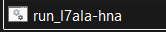